# Hybrid Model Classification Pipeline
This notebook implements a hybrid classification approach combining:
- **RoBERTa** for trial text encoding
- **MLP** for metadata processing
- **Fusion layer** for final classification

In [1]:
import pandas as pd
import re
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from transformers import RobertaTokenizer, RobertaModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import os

os.environ["WANDB_DISABLED"] = "true"

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using NVIDIA GPU (CUDA)")
else:
    device = torch.device("cpu")
    print("Using CPU")

/opt/anaconda3/envs/skripsi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using Apple Silicon GPU (MPS)


## Data Loading and Initial Cleaning

In [2]:
csv_path = "../dataset/OBC_Cleaned_Hybrid.csv"
df = pd.read_csv(csv_path)

df = df.dropna(how="all")

print("Initial dataset shape:", df.shape)
print("\nColumns:", list(df.columns))
print("\nVerdict distribution:")
print(df["Verdict"].value_counts())
print("\nOffence distribution:")
print(df["Offence"].value_counts())
print("\nDefendant Gender distribution:")
print(df["Defendant_Gender"].value_counts())
print("\nVictim Gender distribution:")
print(df["Victim_Gender"].value_counts())

Initial dataset shape: (43389, 11)

Columns: ['Trial_ID', 'Date', 'Defendant_Gender', 'Num_Defendants', 'Victim_Gender', 'Num_Victims', 'Verdict', 'Offence', 'Offence_Subcategory', 'Year', 'Trial_Text']

Verdict distribution:
Verdict
guilty       31253
notGuilty    12136
Name: count, dtype: int64

Offence distribution:
Offence
theft            35684
violentTheft      2410
deception         1436
breakingPeace     1204
sexual            1069
kill              1050
royalOffences      234
miscellaneous      152
damage             150
Name: count, dtype: int64

Defendant Gender distribution:
Defendant_Gender
male             32390
female           10956
indeterminate       43
Name: count, dtype: int64

Victim Gender distribution:
Victim_Gender
male             36157
female            5958
indeterminate     1274
Name: count, dtype: int64


## Data Preprocessing

In [3]:
df = df.drop_duplicates(subset="Trial_ID", keep="first")
df = df.drop_duplicates(subset="Trial_Text", keep="first")
df = df.drop(columns=["Date"], errors="ignore")
df = df[df["Offence"] != "Unknown"]

print("After removing duplicates and unknowns:", df.shape)
print("\nVerdict distribution:")
print(df["Verdict"].value_counts())
print("\nOffence distribution:")
print(df["Offence"].value_counts())

After removing duplicates and unknowns: (43389, 10)

Verdict distribution:
Verdict
guilty       31253
notGuilty    12136
Name: count, dtype: int64

Offence distribution:
Offence
theft            35684
violentTheft      2410
deception         1436
breakingPeace     1204
sexual            1069
kill              1050
royalOffences      234
miscellaneous      152
damage             150
Name: count, dtype: int64


## Balance Dataset

In [4]:
df_not_guilty = df[df['Verdict'] == 'notGuilty'].copy()
df_guilty = df[df['Verdict'] == 'guilty'].copy()

total_not_guilty = len(df_not_guilty)
total_guilty = len(df_guilty)

print("Before balancing:")
print(f"Total notGuilty: {total_not_guilty}")
print(f"Total guilty: {total_guilty}")
print(f"Difference: {abs(total_not_guilty - total_guilty)}\n")

if total_guilty > total_not_guilty:
    df_guilty_sampled = df_guilty.sample(n=total_not_guilty, random_state=42)
    df = pd.concat([df_not_guilty, df_guilty_sampled])
elif total_not_guilty > total_guilty:
    df_not_guilty_sampled = df_not_guilty.sample(n=total_guilty, random_state=42)
    df = pd.concat([df_not_guilty_sampled, df_guilty])
else:
    df = pd.concat([df_not_guilty, df_guilty])

print("After balancing:")
print(df["Verdict"].value_counts())

Before balancing:
Total notGuilty: 12136
Total guilty: 31253
Difference: 19117

After balancing:
Verdict
notGuilty    12136
guilty       12136
Name: count, dtype: int64


## Text Cleaning Pipeline

In [5]:
def clean_text_pipeline(text):
    """Apply all text cleaning steps in sequence"""
    text = str(text)

    text = re.sub(r'^[\W\d\s]+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    text = re.sub(r'[+*FO]+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    if pd.notna(text):
        text = re.sub(r'(?<=\w)\.(?=[A-Z])', '. ', text)
        text = re.sub(r'\s+([.,!?])', r'\1', text)
        text = re.sub(r"Prisoner s", "Prisoner's", text)
        text = re.sub(r'(\d+)\s*d\s*\.', r'\1d.', text)

    return text.strip()

df['Trial_Text'] = df['Trial_Text'].apply(clean_text_pipeline)
print("Text cleaning complete")
print(f"Sample cleaned text:\n{df['Trial_Text'].iloc[0][:200]}...")

Text cleaning complete
Sample cleaned text:
John Bowen was indicted for that he on the 24th of ebruary between the hour of twelve and one in the morning the dwelling house of William Gwinn did break and enter and stealing out thence twenty yard...


## NLP Preprocessing (Tokenization, Lemmatization, Stopword Removal)

In [6]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

nltk_data_dir = "../data-parsing/nltk_data"
nltk.data.path.append(nltk_data_dir)
os.makedirs(nltk_data_dir, exist_ok=True)

for resource in ['punkt', 'wordnet', 'omw-1.4', 'averaged_perceptron_tagger_eng', 'stopwords']:
    nltk.download(resource, download_dir=nltk_data_dir, quiet=True)

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def preprocess_text(text):
    try:
        if not isinstance(text, str):
            return ""

        text = re.sub(r'^\s*[TM]\.\s*', '', text)
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = re.sub(r'\b\w{1,2}\b', '', text)

        sentences = sent_tokenize(text)
        cleaned_sentences = []

        for sentence in sentences:
            words = word_tokenize(sentence.lower())
            words = [word for word in words if word not in stop_words]
            tagged_words = pos_tag(words)
            lemmatized_words = [
                lemmatizer.lemmatize(word, get_wordnet_pos(tag))
                for word, tag in tagged_words
            ]
            cleaned_sentences.append(" ".join(lemmatized_words))

        return " ".join(cleaned_sentences)

    except Exception as e:
        print(f"] Failed to process text: {e}")
        return text

print("Applying NLP preprocessing (this may take a while)...")
df["Trial_Text"] = df["Trial_Text"].astype(str).apply(preprocess_text)
print("NLP preprocessing complete")
print(f"Sample preprocessed text:\n{df['Trial_Text'].iloc[0][:200]}...")

Applying NLP preprocessing (this may take a while)...
NLP preprocessing complete
Sample preprocessed text:
john bowen indict ebruary hour twelve one morning dwelling house william gwinn break enter steal thence twenty yard linnen cheque thirty cotton handkerchief seventy nine yard stripe cotton six pair wo...


## Metadata Preprocessing

In [7]:
# Define metadata columns for the hybrid model
metadata_columns = ['Defendant_Gender', 'Victim_Gender', 'Offence', 'Offence_Subcategory', 'Num_Defendants', 'Num_Victims', 'Year']

# Verify all metadata columns exist
for col in metadata_columns:
    if col not in df.columns:
        print(f"Warning: Column {col} not found in dataset")

print(f"Metadata columns to use: {metadata_columns}")
print(f"\nSample metadata:")
print(df[metadata_columns].head())

Metadata columns to use: ['Defendant_Gender', 'Victim_Gender', 'Offence', 'Offence_Subcategory', 'Num_Defendants', 'Num_Victims', 'Year']

Sample metadata:
   Defendant_Gender Victim_Gender Offence Offence_Subcategory  Num_Defendants  \
0              male          male   theft            burglary               1   
2              male          male   theft        grandLarceny               1   
4            female          male   theft        grandLarceny               2   
11             male        female   theft      theftFromPlace               1   
14             male          male   theft      theftFromPlace               1   

    Num_Victims  Year  
0             1  1750  
2             1  1750  
4             1  1750  
11            2  1750  
14            1  1750  


In [8]:
# Encode categorical metadata
label_encoders = {}
categorical_cols = ['Defendant_Gender', 'Victim_Gender', 'Offence', 'Offence_Subcategory']
numerical_cols = ['Num_Defendants', 'Num_Victims', 'Year']

for col in categorical_cols:
    le = LabelEncoder()
    df[f"{col}_encoded"] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
    print(f"{col}: {len(le.classes_)} unique values")

# Scale numerical features
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Create metadata feature array
encoded_categorical_cols = [f"{col}_encoded" for col in categorical_cols]
metadata_feature_cols = encoded_categorical_cols + numerical_cols

print(f"\nTotal metadata features: {len(metadata_feature_cols)}")
print(f"Feature columns: {metadata_feature_cols}")

Defendant_Gender: 3 unique values
Victim_Gender: 3 unique values
Offence: 9 unique values
Offence_Subcategory: 50 unique values

Total metadata features: 7
Feature columns: ['Defendant_Gender_encoded', 'Victim_Gender_encoded', 'Offence_encoded', 'Offence_Subcategory_encoded', 'Num_Defendants', 'Num_Victims', 'Year']


## Prepare Data for Model Training

In [9]:
df = df[df["Verdict"].isin(["guilty", "notGuilty"])]

label_map = {"guilty": 1, "notGuilty": 0}
df["Label"] = df["Verdict"].map(label_map)

print(f"Final dataset shape: {df.shape}")
print(f"Label distribution:\n{df['Label'].value_counts()}")

Final dataset shape: (24272, 15)
Label distribution:
Label
0    12136
1    12136
Name: count, dtype: int64


## Define Hybrid Dataset and Model

In [10]:
class HybridCourtDataset(Dataset):
    def __init__(self, texts, metadata, labels, tokenizer, max_len=512):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_len, return_tensors=None)
        self.metadata = metadata
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["metadata"] = torch.tensor(self.metadata[idx], dtype=torch.float32)
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [11]:
class HybridClassifier(nn.Module):
    def __init__(self, roberta_model_name="roberta-base", metadata_dim=7, hidden_dim=256, num_labels=2, dropout=0.3):
        super(HybridClassifier, self).__init__()
        
        # RoBERTa for text encoding
        self.roberta = RobertaModel.from_pretrained(roberta_model_name)
        self.roberta_hidden_size = self.roberta.config.hidden_size  # 768 for roberta-base
        
        # MLP for metadata
        self.metadata_mlp = nn.Sequential(
            nn.Linear(metadata_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # Fusion layer
        self.fusion = nn.Sequential(
            nn.Linear(self.roberta_hidden_size + hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # Classification head
        self.classifier = nn.Linear(hidden_dim, num_labels)
        
    def forward(self, input_ids, attention_mask, metadata, labels=None):
        # Get RoBERTa embeddings
        roberta_output = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        text_features = roberta_output.last_hidden_state[:, 0, :]  # [CLS] token
        
        # Get metadata features
        metadata_features = self.metadata_mlp(metadata)
        
        # Concatenate and fuse
        combined = torch.cat([text_features, metadata_features], dim=1)
        fused = self.fusion(combined)
        
        # Classification
        logits = self.classifier(fused)
        
        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
        
        return {"loss": loss, "logits": logits}

In [12]:
def compute_metrics(preds, labels):
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

## Initialize Tokenizer and Cross-Validation

In [13]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Prepare metadata array
metadata_array = df[metadata_feature_cols].values.astype(np.float32)

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
best_fold = -1
best_model = None
best_tokenizer = None
best_val_acc = 0.0
train_acc_all, val_acc_all = [], []
train_loss_all, val_loss_all = [], []

## Training Function

In [14]:
def train_epoch(model, dataloader, optimizer, scheduler, device, epoch_num, total_epochs):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch_num}/{total_epochs} [Training]", leave=False)
    
    for batch in progress_bar:
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        metadata = batch['metadata'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids, attention_mask, metadata, labels)
        loss = outputs['loss']
        logits = outputs['logits']
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())
        
        # Update progress bar
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy

def eval_epoch(model, dataloader, device, epoch_num, total_epochs):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch_num}/{total_epochs} [Validation]", leave=False)
    
    with torch.no_grad():
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            metadata = batch['metadata'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask, metadata, labels)
            loss = outputs['loss']
            logits = outputs['logits']
            
            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
            
            # Update progress bar
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy

## 10-Fold Cross-Validation Training


Fold 1/10


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch   Train Loss     Train Acc      Val Loss       Val Acc        
--------------------------------------------------------------------


1       0.318798       0.851035       0.206407       0.908567       


2       0.198345       0.912516       0.157493       0.912685       


3       0.170572       0.922359       0.178105       0.912685       


4       0.154148       0.936504       0.237264       0.919687       


5       0.141301       0.948361       0.271389       0.921746       


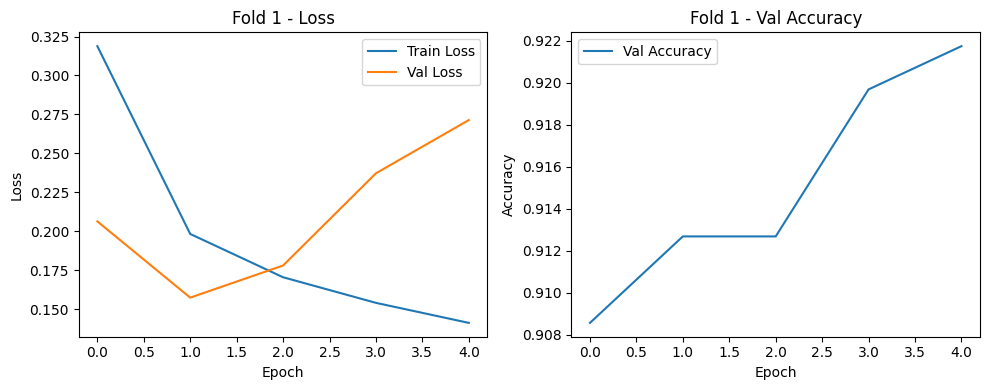


Fold 2/10


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch   Train Loss     Train Acc      Val Loss       Val Acc        
--------------------------------------------------------------------


1       0.322636       0.855338       0.299443       0.900741       


2       0.221840       0.910960       0.226334       0.912685       


3       0.185758       0.927348       0.248915       0.913509       


4       0.161344       0.945797       0.308685       0.917216       


5       0.141190       0.959485       0.352890       0.919687       


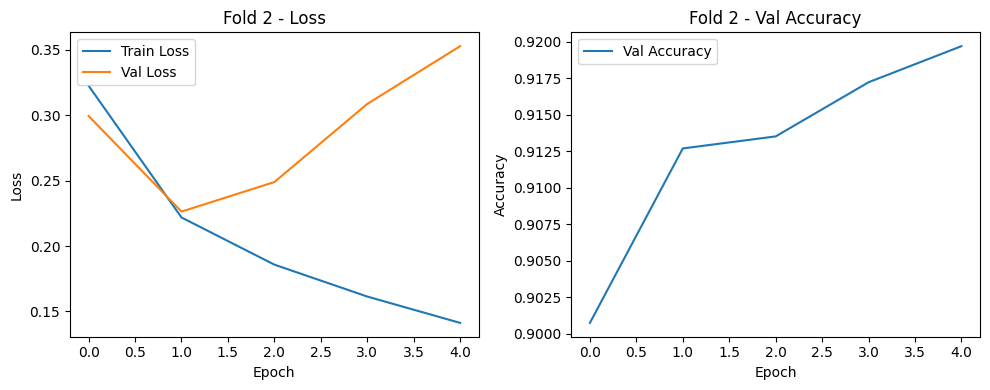


Fold 3/10


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch   Train Loss     Train Acc      Val Loss       Val Acc        
--------------------------------------------------------------------


1       0.323072       0.851911       0.205248       0.912649       


KeyboardInterrupt: 

In [15]:
# Training hyperparameters
BATCH_SIZE = 8
EPOCHS = 5
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 0.01
WARMUP_STEPS = 500
METADATA_DIM = len(metadata_feature_cols)

texts = df["Trial_Text"].tolist()
labels = df["Label"].tolist()

for fold, (train_idx, val_idx) in enumerate(kfold.split(texts, labels)):
    print(f"\n{'='*50}")
    print(f"Fold {fold+1}/10")
    print(f"{'='*50}")

    # Prepare data
    train_texts = [texts[i] for i in train_idx]
    train_labels = [labels[i] for i in train_idx]
    train_metadata = metadata_array[train_idx]
    
    val_texts = [texts[i] for i in val_idx]
    val_labels = [labels[i] for i in val_idx]
    val_metadata = metadata_array[val_idx]

    # Create datasets and dataloaders
    train_dataset = HybridCourtDataset(train_texts, train_metadata, train_labels, tokenizer)
    val_dataset = HybridCourtDataset(val_texts, val_metadata, val_labels, tokenizer)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Initialize model
    model = HybridClassifier(metadata_dim=METADATA_DIM)
    model.to(device)

    # Optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    total_steps = len(train_loader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=WARMUP_STEPS, num_training_steps=total_steps)

    # Training loop
    fold_train_losses = []
    fold_val_losses = []
    fold_val_accs = []
    
    # Create table header
    print(f"\n{'Epoch':<8}{'Train Loss':<15}{'Train Acc':<15}{'Val Loss':<15}{'Val Acc':<15}")
    print("-" * 68)
    
    for epoch in range(EPOCHS):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler, device, epoch+1, EPOCHS)
        val_loss, val_acc = eval_epoch(model, val_loader, device, epoch+1, EPOCHS)
        
        fold_train_losses.append(train_loss)
        fold_val_losses.append(val_loss)
        fold_val_accs.append(val_acc)
        
        print(f"{epoch+1:<8}{train_loss:<15.6f}{train_acc:<15.6f}{val_loss:<15.6f}{val_acc:<15.6f}")

    # Record fold results
    final_val_acc = fold_val_accs[-1]
    final_val_loss = fold_val_losses[-1]
    val_acc_all.append(final_val_acc)
    val_loss_all.append(final_val_loss)
    train_loss_all.append(fold_train_losses[-1])

    # Save best model (from last fold as in original)
    if fold == 9:
        best_val_acc = final_val_acc
        best_fold = fold
        best_model = model
        best_tokenizer = tokenizer

    # Plot fold results
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(fold_train_losses, label="Train Loss")
    plt.plot(fold_val_losses, label="Val Loss")
    plt.title(f"Fold {fold+1} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(fold_val_accs, label="Val Accuracy")
    plt.title(f"Fold {fold+1} - Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Clean up
    del model
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

## Save Best Model

In [ ]:
final_model_path = "../models/hybrid_roberta_final_best_model"
os.makedirs(final_model_path, exist_ok=True)

# Save the hybrid model
torch.save(best_model.state_dict(), os.path.join(final_model_path, "hybrid_model.pt"))
best_tokenizer.save_pretrained(final_model_path)

# Save label encoders and scaler
import pickle
with open(os.path.join(final_model_path, "label_encoders.pkl"), "wb") as f:
    pickle.dump(label_encoders, f)
with open(os.path.join(final_model_path, "scaler.pkl"), "wb") as f:
    pickle.dump(scaler, f)

print(f"Model saved to {final_model_path}")

## Final Results

In [ ]:
print("\n" + "="*60)
print("HYBRID MODEL - 10-FOLD CROSS-VALIDATION RESULTS")
print("="*60)
print(f"\nFinal model saved from best fold: {best_fold + 1}")
print(f"Mean Validation Accuracy (10-fold): {np.mean(val_acc_all):.4f} (+/- {np.std(val_acc_all):.4f})")
print(f"Mean Train Loss (10-fold): {np.mean(train_loss_all):.4f}")
print(f"Mean Val Loss (10-fold): {np.mean(val_loss_all):.4f}")
print(f"\nMetadata features used: {metadata_feature_cols}")
print(f"\nFold-wise validation accuracies:")
for i, acc in enumerate(val_acc_all):
    print(f"  Fold {i+1}: {acc:.4f}")